The following is a basic code I've constructed just to resize the image and output it. This is going to require a lot more work, but I just wanted to take one shot at it to see how it goes.


In [ ]:
#Imports for the specific code
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt


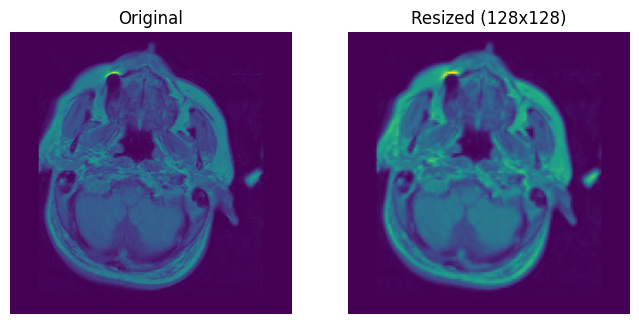

In [ ]:
#load the URL for my GitHub
url = "https://raw.githubusercontent.com/Aditsmishra2005/APS360---Project/a196288235d31cf3424d16974f04825152ef569a/parkinsons_dataset1/parkinson/DUAL_TSE_001.png"
result = requests.get(url)
photo = Image.open(BytesIO(result.content))

photo_resized = photo.resize((128,128))
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

#Duisplay the Original for a reference
axes[0].imshow(photo)
axes[0].set_title("Original")
axes[0].axis("off")

#Display the resized for a reference
axes[1].imshow(photo_resized)
axes[1].set_title("Resized (128x128)")
axes[1].axis("off")

plt.show()

Okay following the intial documentation shown above I decided to construct my model, my base model is an ANN and I planned to do some basic data augmentation to increase the data quantity I have. I planned to use the Lab Three framework to import my dataset from google drive.

In [126]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now I load the dataset, and to do this I basically uploaded all the images from my dataset to the drive.

In [ ]:
import torchvision.datasets as d
data = d.ImageFolder('/content/drive/My Drive/Colab Notebooks/parkinsons_dataset1')

In [144]:
paths = [sample[0] for sample in data.samples]  # or data.imgs
labels = [sample[1] for sample in data.samples]

Now I plan to just check that the data is imported.

In [145]:
print(len(data)) # with this I can see that the amount of datasets are complete.

1662


This next portion is the deletion portion if the rotated images are too many then I do this, but I'm only doubling my dataset. So only run it if I need to delete data.

In [ ]:
base_path = '/content/drive/My Drive/Colab Notebooks/parkinsons_dataset1'#set the paths
classes = ['normal', 'parkinson'] #Adjusting the classes as needed

for cls in classes:
    class_directory = os.path.join(base_path, cls)
    for name in os.listdir(class_directory):
        if '_rot' in name:
            file_path = os.path.join(class_directory, name)
            print(f"Deleting {file_path}")
            os.remove(file_path)

Doubling the dataset by performing roations, this is my main form of augmentation. I will say that this was largely Perplexity generated. I know I would normall have to disclose this, but I did modify the code slightly. Not very familiar with heavy data augmentation.

In [ ]:
from PIL import Image
import os
import random

# setting the correct path
base_path = '/content/drive/My Drive/Colab Notebooks/parkinsons_dataset1'
classes = ['normal', 'parkinson']   # names of the two classes I have

angle_range = (-30, 30)  # Can't rotate it too much, because in medical imaging x-rays are taken at certain angles anyways and certain directions.

for cls in classes: #makes sense
    class_directory = os.path.join(base_path, cls)
    for name in os.listdir(class_directory):
        if name.endswith('.jpg') or name.endswith('.png'):
            img_path = os.path.join(class_directory, name)
            img = Image.open(img_path)#grab original image
            angle = random.randint(*angle_range)#rotate using the angle range
            rotated_img = img.rotate(angle)
            new_fname = f"{os.path.splitext(name)[0]}_rot{angle}{os.path.splitext(name)[1]}"#save with new name
            rotated_img.save(os.path.join(class_directory, new_fname))


Check the new total dataset amounts!

In [ ]:
data = d.ImageFolder('/content/drive/My Drive/Colab Notebooks/parkinsons_dataset1')

In [ ]:
print(len(data)) #data has officially doubled now

1662


The next portion is going to be me resizing the images by making them all 128x128. I'm going to replace the images all in the google drive folder.

In [ ]:
target_size = (128, 128) #Looking at 128x128 so a total of 16,384 features
for cls in classes:
    class_directory = os.path.join(base_path, cls)
    for name in os.listdir(class_directory):
        if name.endswith('.jpg') or name.endswith('.png'):
            img_path = os.path.join(class_directory, name)
            img = Image.open(img_path)
            img_resized = img.resize(target_size)

            img_resized.save(img_path)#save the resized image to the appropriate path

Now that all my data is processed and ready I'm going to seperate it using SK learn. I'm going to set aside a certain amount of my data to test on, and this will be used for the later verification of my models.

In [71]:
X = []
y = []

for img, label in data:
    img_arr = np.array(img).astype(np.float32) / 255.0  # scale to [0, 1]
    X.append(img_arr.flatten())
    y.append(label)

X = np.array(X)
y = np.array(y)

In the above I've normalized for the SVM to take in as an input

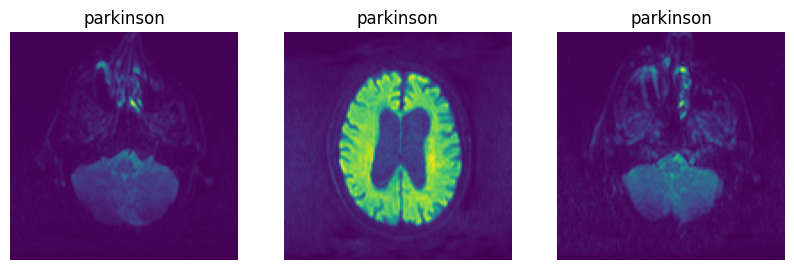

In [143]:
for cls in classes:
    class_dir = os.path.join(base_path, cls)
    images = [f for f in os.listdir(class_dir) if f.endswith('.jpg') or f.endswith('.png')]

plt.figure(figsize=(10,3))
for i, img_name in enumerate(images[:3]):  # first 3 images
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(1,3,i+1)
        plt.imshow(img)
        plt.title(f"{cls}")
        plt.axis('off')
plt.show()

Showing the example images of the data that will be processed.

In [105]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)#Copied from lab 3 but basis is that do an 80-20 split. The test size is 20% of the total data
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)#We make the validation 16% of the total data, and 64% to train

Now that I've split my data, my main goal is going to be to now create a baseline model. I've decided to change my model. Specifically because the ANN doesn't seem to be a good idea for training images. On the other hand due to the nature of the classification task I was thinking of using SVM. This however is different to my proposal, and it will be altered in the progress report.

In [73]:
#Starting the code for the SVM also use other imports that I know are good for accuracy and Kfolds
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [74]:
clf = svm.SVC(kernel='linear', probability=True)#using a linear model on the SVM because I think this would work best. Might alter it depending on accuracy.
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)#use shuffles, and 10 splits of the kfold

train_errs = []
val_errs = []

for train_idx, valid_idx in cv.split(X_train, y_train):
    clf.fit(X_train[train_idx], y_train[train_idx])
    y_train_pred = clf.predict(X_train[train_idx])
    y_valid_pred = clf.predict(X_train[valid_idx])
    train_errs.append(1 - accuracy_score(y_train[train_idx], y_train_pred))
    val_errs.append(1 - accuracy_score(y_train[valid_idx], y_valid_pred))

# Final fit and test accuracy
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)



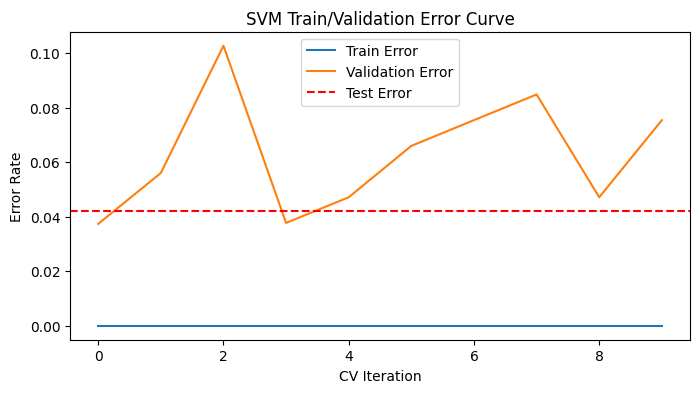

Accuracy Score: 0.9579579579579579


In [75]:
plt.figure(figsize=(8,4))
plt.plot(range(len(train_errs)), train_errs, label='Train Error')
plt.plot(range(len(val_errs)), val_errs, label='Validation Error')
plt.axhline(1 - test_accuracy, color='r', linestyle='--', label='Test Error')
plt.xlabel('CV Iteration')
plt.ylabel('Error Rate')
plt.title('SVM Train/Validation Error Curve')
plt.legend()
plt.show()

print("Accuracy Score:", test_accuracy)


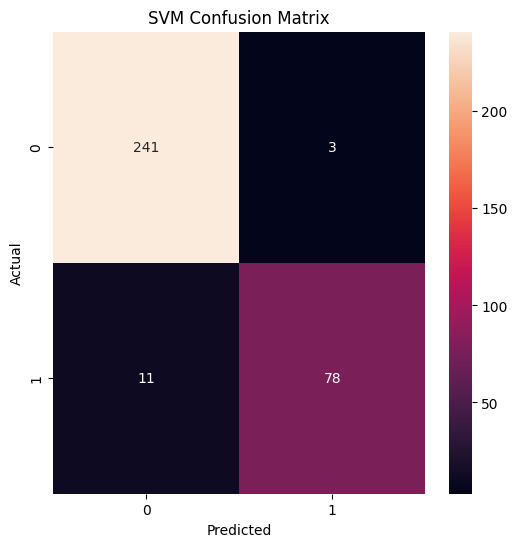

In [165]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The next section will focus on the creation of the Primary model which we will tune to fit the dataset.

In [153]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

data_dir = '/content/drive/My Drive/Colab Notebooks/parkinsons_dataset1'
# Assumes each class has its own subfolder
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)


In [169]:
train_len = int(0.8 * len(full_dataset)) #80-20 split
val_len = len(full_dataset) - train_len
train_ds, val_ds = random_split(full_dataset, [train_len, val_len])

In [155]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

The above is all stuff we have done prior in terms of splitting the data. I could've done a better job potentially with the splitting

In [168]:
import torch.nn as nn
import torch.nn.functional as F

class ParkinsonNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ParkinsonNet, self).__init__()
        self.name = "parkinsonnet"
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*32*32, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_out(x)
        return x

Setting up the architecture for my model.

In [151]:
def trainnet(net, batchsize, learning_rate, epoch, train_dataset, val_dataset):
    optimizer = optim.SGD (net.parameters(), lr=learning_rate, momentum=0.7)
    loss_func = nn.CrossEntropyLoss()

    train_error = np.zeros(epoch)
    train_loss = np.zeros(epoch)
    val_error = np.zeros(epoch)
    val_loss = np.zeros(epoch)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batchsize, shuffle=False)

    for e in range(epoch):
        total_train_samples = 0
        train_loss_sum = 0.0
        train_error_sum = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            output = net(images)
            loss = loss_func(output, labels)
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item() * images.size(0)
            _, predicted = torch.max(output.data, 1)
            train_error_sum += (predicted != labels).sum().item()
            total_train_samples += labels.size(0)
        train_loss[e] = train_loss_sum / total_train_samples
        train_error[e] = train_error_sum / total_train_samples
        # Validation after each epoch
        val_error[e], val_loss[e] = evaluate(net, val_loader, loss_func)
        print(f"Epoch {e+1}: Train loss: {train_loss[e]:.4f}, Train error: {train_error[e]:.4f}, Val loss: {val_loss[e]:.4f}, Val error: {val_error[e]:.4f}")
        model_path = get_model_name(net.name, batchsize, learning_rate, e + 1)
        torch.save(net.state_dict(), model_path)
    np.savetxt("{}_train_err.csv".format(model_path), train_error)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_error)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

Training net code from the model. I don't have the evaluate function added because I didn't think it was needed just yet.

In [156]:
model = ParkinsonNet()
trainnet(model, 16, 0.001, 20, train_ds, val_ds)

Epoch 1: Train loss: 0.6736, Train error: 0.4281, Val loss: 0.6267, Val error: 0.3033
Epoch 2: Train loss: 0.5869, Train error: 0.2566, Val loss: 0.6199, Val error: 0.3033
Epoch 3: Train loss: 0.5809, Train error: 0.2566, Val loss: 0.6185, Val error: 0.3033
Epoch 4: Train loss: 0.5791, Train error: 0.2566, Val loss: 0.6148, Val error: 0.3033
Epoch 5: Train loss: 0.5745, Train error: 0.2566, Val loss: 0.6239, Val error: 0.3033
Epoch 6: Train loss: 0.5702, Train error: 0.2566, Val loss: 0.6089, Val error: 0.3033
Epoch 7: Train loss: 0.5651, Train error: 0.2566, Val loss: 0.6084, Val error: 0.3033
Epoch 8: Train loss: 0.5589, Train error: 0.2566, Val loss: 0.5979, Val error: 0.3033
Epoch 9: Train loss: 0.5487, Train error: 0.2566, Val loss: 0.5954, Val error: 0.3033
Epoch 10: Train loss: 0.5343, Train error: 0.2566, Val loss: 0.6122, Val error: 0.3033
Epoch 11: Train loss: 0.5167, Train error: 0.2566, Val loss: 0.5508, Val error: 0.3033
Epoch 12: Train loss: 0.4918, Train error: 0.2408, V

Running the model over 20 epochs with a small batch size.

In [157]:
# Model function taken directly from Lab2 to help with data checkpoints and plotting
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [158]:
def plot_training_curve(path): #copied Lab 2
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_error = np.loadtxt("{}_train_err.csv".format(path))
    val_error = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_error) # number of epochs
    plt.plot(range(1,n+1), train_error, label="Train")
    plt.plot(range(1,n+1), val_error, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

Code to get the model path and graph the model

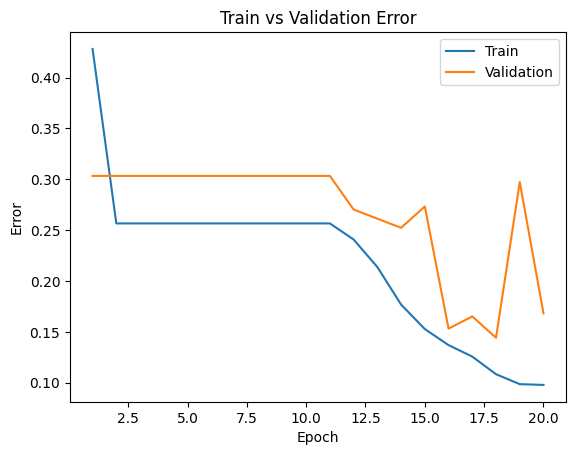

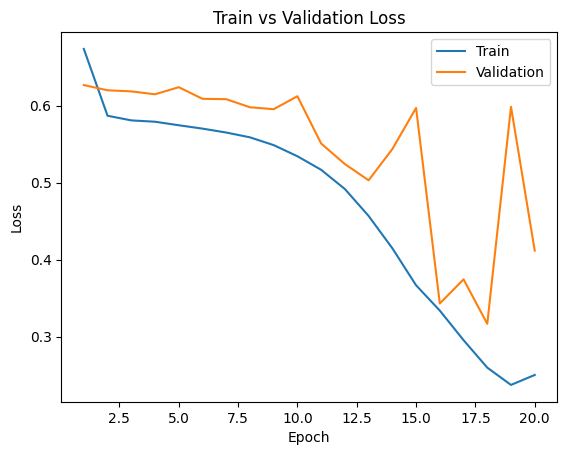

In [163]:
model_path = get_model_name("parkinsonnet", batch_size=16, learning_rate=0.001, epoch=20)
plot_training_curve(model_path)

Plotting the training curves.